### 전체 Process  
1. 해당 읍/면/동 shapefile 전부 불러오기
2. 용도지역 확인하고 튀는 용도지역이 있는지 체크하기
3. shapefile 합치기
4. 각종 용도지역과 도로 구분해서 색칠하기
5. shapefile을 한꺼번에 커버할 수 있는 크기 찾기
6. 해당 크기에서 중심 point 뽑고, 지도 안에 위치하는지 확인하기
7. point를 중심으로 Shapefile 일정 크기로 자르기
8. picture로 내보내기
9. 내보낸 picture에 특정 색상이 비율이 너무 큰 것들 분류

In [1]:
# Setting Libraries

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import matplotlib
import ast
from shapely.geometry import Point, LineString, Polygon
from tqdm import tqdm

# Setting matplotlib
# matplotlib.font_manager._rebuild()
plt.rcParams['axes.facecolor'] = 'black'

### 1. 해당 읍/면/동 shapefile 전부 불러오기

In [2]:
ei = 1

In [3]:
# 어디 파일이 들어있는지, 몇 번째 파일들을 가져올 것인지
# mainpath의 몇 번째 폴더에서 shapefile을 전부 가져와라

def get_shplist(ith:int=1, mainpath:str="Data"):
    folders = glob.glob(mainpath + "/*")
    file_directory = glob.glob(folders[ith] + "/*")
    shps = [file for file in file_directory if file.endswith(".shp")]
    return shps

In [4]:
shp_asan = get_shplist(ei)

In [5]:
shp_asan

['Data/Doan/AL_30170_D194_20211129.shp',
 'Data/Doan/AL_30200_D194_20211129.shp']

### 2. 용도지역 확인하고 튀는 용도지역이 있는지 체크하기

In [6]:
def get_yongdos(shplist:list):
    yongdos = []
    for i in shplist:
        temp = gpd.read_file(i, encoding = 'cp949')
        temp_yongdo = temp['A14'].unique()
        for j in temp_yongdo:
            if j not in yongdos:
                yongdos.append(j)
#                 print(yongdos)
    return yongdos

In [7]:
# get yongdos from every sidos
gg_yongdo_list = get_yongdos(shp_asan)
print(gg_yongdo_list)

['자연녹지지역', None, '제3종일반주거지역', '보전녹지지역', '제2종일반주거지역', '제1종일반주거지역', '일반상업지역', '근린상업지역', '준주거지역', '개발제한구역', '중심상업지역', '생산녹지지역', '제1종전용주거지역', '일반공업지역', '생산관리지역', '농림지역', '준공업지역', '보전관리지역', '계획관리지역', '유통상업지역']


In [8]:
def check_outliers(yongdo_list:list, color_dict:dict):
    outliers = []
    for yongdo in yongdo_list:
        if yongdo in color_dict:
            continue
        else:
            outliers.append(yongdo)
    return outliers

In [118]:
color_dict = {
    '제1종일반주거지역':'#ffff66',
    '제2종일반주거지역':'#ffff00',
    '제3종일반주거지역':'#ffcc00',
    '준주거지역':'#ffff00',
    '제1종전용주거지역':'#ffff66',
    '제2종전용주거지역':'#ffff00',
    '일반상업지역':'#ff66cc',
    '근린상업지역':'#ff66dd',
    '중심상업지역':'#ff66ff',
    '유통상업지역':'#ff66ee',
    '일반공업지역':'#cc66ff',
    '준공업지역':'#cc77ff',
    '전용공업지역':'#cc88ff',
    '개발제한구역':'#66ffff',
    '자연녹지지역':'#ccff66',
    '보전녹지지역':'#ccff55',
    '생산녹지지역':'#ccff44', 
    '보전관리지역':'#ccff33',
    '계획관리지역':'#fd4758',
    '생산관리지역':'#ccff22',
    '관리지역':'#fd4766',
    '농림지역':'#ccff11',
    '자연환경보전지역':'#ccffff',
    None:'#000000',
    '용도미지정':'#ffffff'
}

In [119]:
outliers = check_outliers(gg_yongdo_list, color_dict)
print(outliers)

[]


In [120]:
# # color dictionary 만들고 load하기

# import json
# color_json = json.dumps(color_dict)

# with open('color.json', 'w', encoding='UTF-8') as file:
#     file.write(json.dumps(color_dict, ensure_ascii=False))
    
# with open('color.json', 'r', encoding='utf-8') as f:
#     jsondict = json.load(f)

In [121]:
# def check_outliers(yongdo_list:list, color_dict:dict):
#     outliers = []
#     for yongdo in yongdo_list:
#         if yongdo in color_dict:
#             continue
#         else:
#             outliers.append(yongdo)
#     return outliers

# outliers = check_outliers(gg_yongdo_list, jsondict)
# print(outliers)

### 3. Shapefile 합치기

In [122]:
def concat_shp(shplist:list):
    return gpd.GeoDataFrame(pd.concat([gpd.read_file(i, encoding = 'cp949') for i in shplist], 
                        ignore_index=True), crs="EPSG:5174")

In [123]:
gdf = concat_shp(shp_asan)

### 4. 각종 용도지역과 도로 구분해서 색칠하기

In [124]:
# get the color of the dataframe

def get_gdf_color(gdf:gpd.GeoDataFrame):
    
    def get_color(line):
        isdoro = line['A11']
        if isdoro == '도로':
            return '#ffffaa'
        
        name = line['A14']
        if name == 'None':
            name = ast.literal_eval(name)
        if name in color_dict:
            return color_dict[name]
        
#     def get_street_color(name:str):
#         if name == '도로':
#             return '#ffffaa'

    # get color based on yongdo
    gdf['use'] = gdf.apply(get_color, axis=1)
    
    return gdf

In [125]:
gdf = get_gdf_color(gdf)

In [126]:
gdf['use'].head()

0    #ccff66
1    #000000
2    #000000
3    #000000
4    #000000
Name: use, dtype: object

### 5. shapefile을 한꺼번에 커버할 수 있는 크기 찾기

In [127]:
def get_bounds(gdf:gpd.GeoDataFrame):
    bounds = gdf.total_bounds
    
    # bounds = [minx, miny, maxx, maxy]
    # counter-clockwise from the lower left
    
#     point1 = Point(bounds[0], bounds[1])
#     point2 = Point(bounds[2], bounds[1])
#     point3 = Point(bounds[2], bounds[3])
#     point4 = Point(bounds[0], bounds[3])
#     poly = Polygon([point1, point2, point3, point4])
#     poly = gpd.GeoSeries(poly)
    
    return bounds

In [128]:
poly = get_bounds(gdf)

In [129]:
poly

array([222085.484, 298106.793, 237622.206, 333313.933])

### 6. 해당 크기에서 중심 point 뽑고, 지도 안에 위치하는지 확인하기

In [130]:
def get_points(bounds, interval:int):
    middle_points = []
    
    for x in range(int(bounds[0]), int(bounds[2]), interval): # x coordinates:
        for y in range(int(bounds[1]), int(bounds[3]), interval): # y coordinates:
            middle_points.append([x, y])
    
    return middle_points

In [131]:
def get_onlyinmap(polygon:gpd.GeoSeries, points:list):
    def is_in(polygon:gpd.GeoSeries, point:list):
        p = Point(point[0], point[1])
        if_contains = polygon.contains(p, align=False)
        return if_contains.any()

    for point in tqdm(points[:]):
        if not is_in(polygon, point):
            points.remove(point)
    
    return points

In [132]:
middle_points = get_points(poly, 500)
middle_points_renew = get_onlyinmap(gdf['geometry'], middle_points)
print(middle_points_renew)

100%|████████████████████████████████████████████████████████████| 2272/2272 [07:40<00:00,  4.93it/s]

[[222585, 309606], [222585, 310106], [222585, 310606], [223085, 308606], [223085, 309106], [223085, 309606], [223085, 310106], [223585, 308606], [223585, 309106], [223585, 309606], [223585, 310106], [223585, 310606], [223585, 311106], [223585, 311606], [223585, 312106], [223585, 312606], [223585, 313106], [223585, 313606], [224085, 308106], [224085, 308606], [224085, 309106], [224085, 309606], [224085, 310106], [224085, 310606], [224085, 311106], [224085, 311606], [224085, 312106], [224085, 312606], [224085, 313106], [224085, 313606], [224085, 314106], [224085, 314606], [224085, 315106], [224085, 315606], [224585, 307606], [224585, 308106], [224585, 308606], [224585, 309106], [224585, 309606], [224585, 310106], [224585, 310606], [224585, 311106], [224585, 311606], [224585, 312106], [224585, 312606], [224585, 313106], [224585, 313606], [224585, 314106], [224585, 314606], [224585, 315106], [224585, 315606], [224585, 317106], [224585, 317606], [224585, 318106], [225085, 307606], [225085, 

### 7. point를 중심으로 Shapefile 일정 크기로 자르기

In [133]:
def get_molds(middle_points:list, side_length = 500):
    molds = []
    half_length = side_length / 2
        
    for point in tqdm(middle_points):
        middlex = point[0]
        middley = point[1]

        point1 = Point(middlex - half_length, middley - half_length)
        point2 = Point(middlex + half_length, middley - half_length)
        point3 = Point(middlex + half_length, middley + half_length)
        point4 = Point(middlex - half_length, middley + half_length)

        poly = Polygon([point1, point2, point3, point4])
        mpoly = gpd.GeoSeries(poly, crs="EPSG:5174")
        molds.append(poly)
            
    return molds

In [134]:
def get_clipped(gdf:gpd.GeoDataFrame, mold:gpd.GeoSeries):
    clipped = gpd.clip(gdf, mold)
    return clipped

In [135]:
molds = get_molds(middle_points_renew, 3000)

100%|███████████████████████████████████████████████████████████| 1083/1083 [00:05<00:00, 191.95it/s]


In [136]:
len(molds)

1083

In [137]:
str(molds[0])

'POLYGON ((221085 308106, 224085 308106, 224085 311106, 221085 311106, 221085 308106))'

In [138]:
c = get_clipped(gdf, molds[0])

In [139]:
c.head()
# c.empty

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A19,A20,A21,A22,A23,A24,A25,A26,geometry,use
73059,369153252,3020010800103890001,3020010800,대전광역시 유성구 세동,1,일반,389-1,389-1대,2021,01,...,03,완경사,04,사다리형,08,세로한면(가),260700.0,2021-11-15,"POLYGON ((223919.288 310493.707, 223917.182 31...",#66ffff
76040,369093391,3020010900200030002,3020010900,대전광역시 유성구 송정동,2,산,3-2,산3-2임,2021,01,...,04,급경사,04,사다리형,12,맹지,3050.0,2021-11-15,"POLYGON ((223489.687 310636.301, 223549.648 31...",#66ffff
76038,369092964,3020010900200020000,3020010900,대전광역시 유성구 송정동,2,산,2,산2임,2021,01,...,04,급경사,04,사다리형,12,맹지,3010.0,2021-11-15,"POLYGON ((223780.839 310641.668, 223830.514 31...",#66ffff
76245,369096762,3020010900200670000,3020010900,대전광역시 유성구 송정동,2,산,67,산67구,None,None,...,None,None,None,None,None,None,NaN,2021-11-15,"POLYGON ((223579.181 310710.131, 223576.791 31...",#000000
72853,369111024,3020010800102850000,3020010800,대전광역시 유성구 세동,1,일반,285,285답,2021,01,...,04,급경사,05,부정형,12,맹지,37100.0,2021-11-15,"POLYGON ((224085.000 310619.951, 224085.000 31...",#66ffff


### 8. Picture로 내보내기

In [140]:
import os

folders = os.listdir("Data")
folders

['Uirye',
 'Doan',
 'Geomdan',
 'Ilsan',
 'Gwanggyo',
 'Hangang',
 'Asan',
 'Bundang',
 'Sanbon',
 'Pyeongchon',
 'Dongtan',
 'Joongdong',
 'Woonjeong',
 'Godeog',
 'Yangju']

In [141]:
city = 'Doan'
i = 0

filename = path + "/" + city + "_" + str(i) + '.png'

def save_to_pic(gdf:gpd.GeoDataFrame, filename:str):
    plt.figure(figsize = (20, 20), dpi=200)
    # plt.rcParams['font.family'] = 'Malgun Gothic'
    sample_dis = gdf[['geometry', 'A14', 'use']]
    dis = sample_dis.dissolve(by='use')
    dis.reset_index(inplace=True)
    ax = plt.subplot(1, 1, 1)
    ax.axis('off')
    plt.margins(0,0)
    dis.plot(column = 'A14', legend = True, color=dis['use'], axes=ax)

    path = 'result/' + city

    # Check whether the specified path exists or not
    if not os.path.exists(path):
        # Create a new directory because it does not exist 
        os.makedirs(path)
        print("The new directory is created!")

    plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

/home/urban/anaconda3/envs/geo_py39/lib/python3.9/site-packages/geopandas/plotting.py:637: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
/home/urban/anaconda3/envs/geo_py39/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


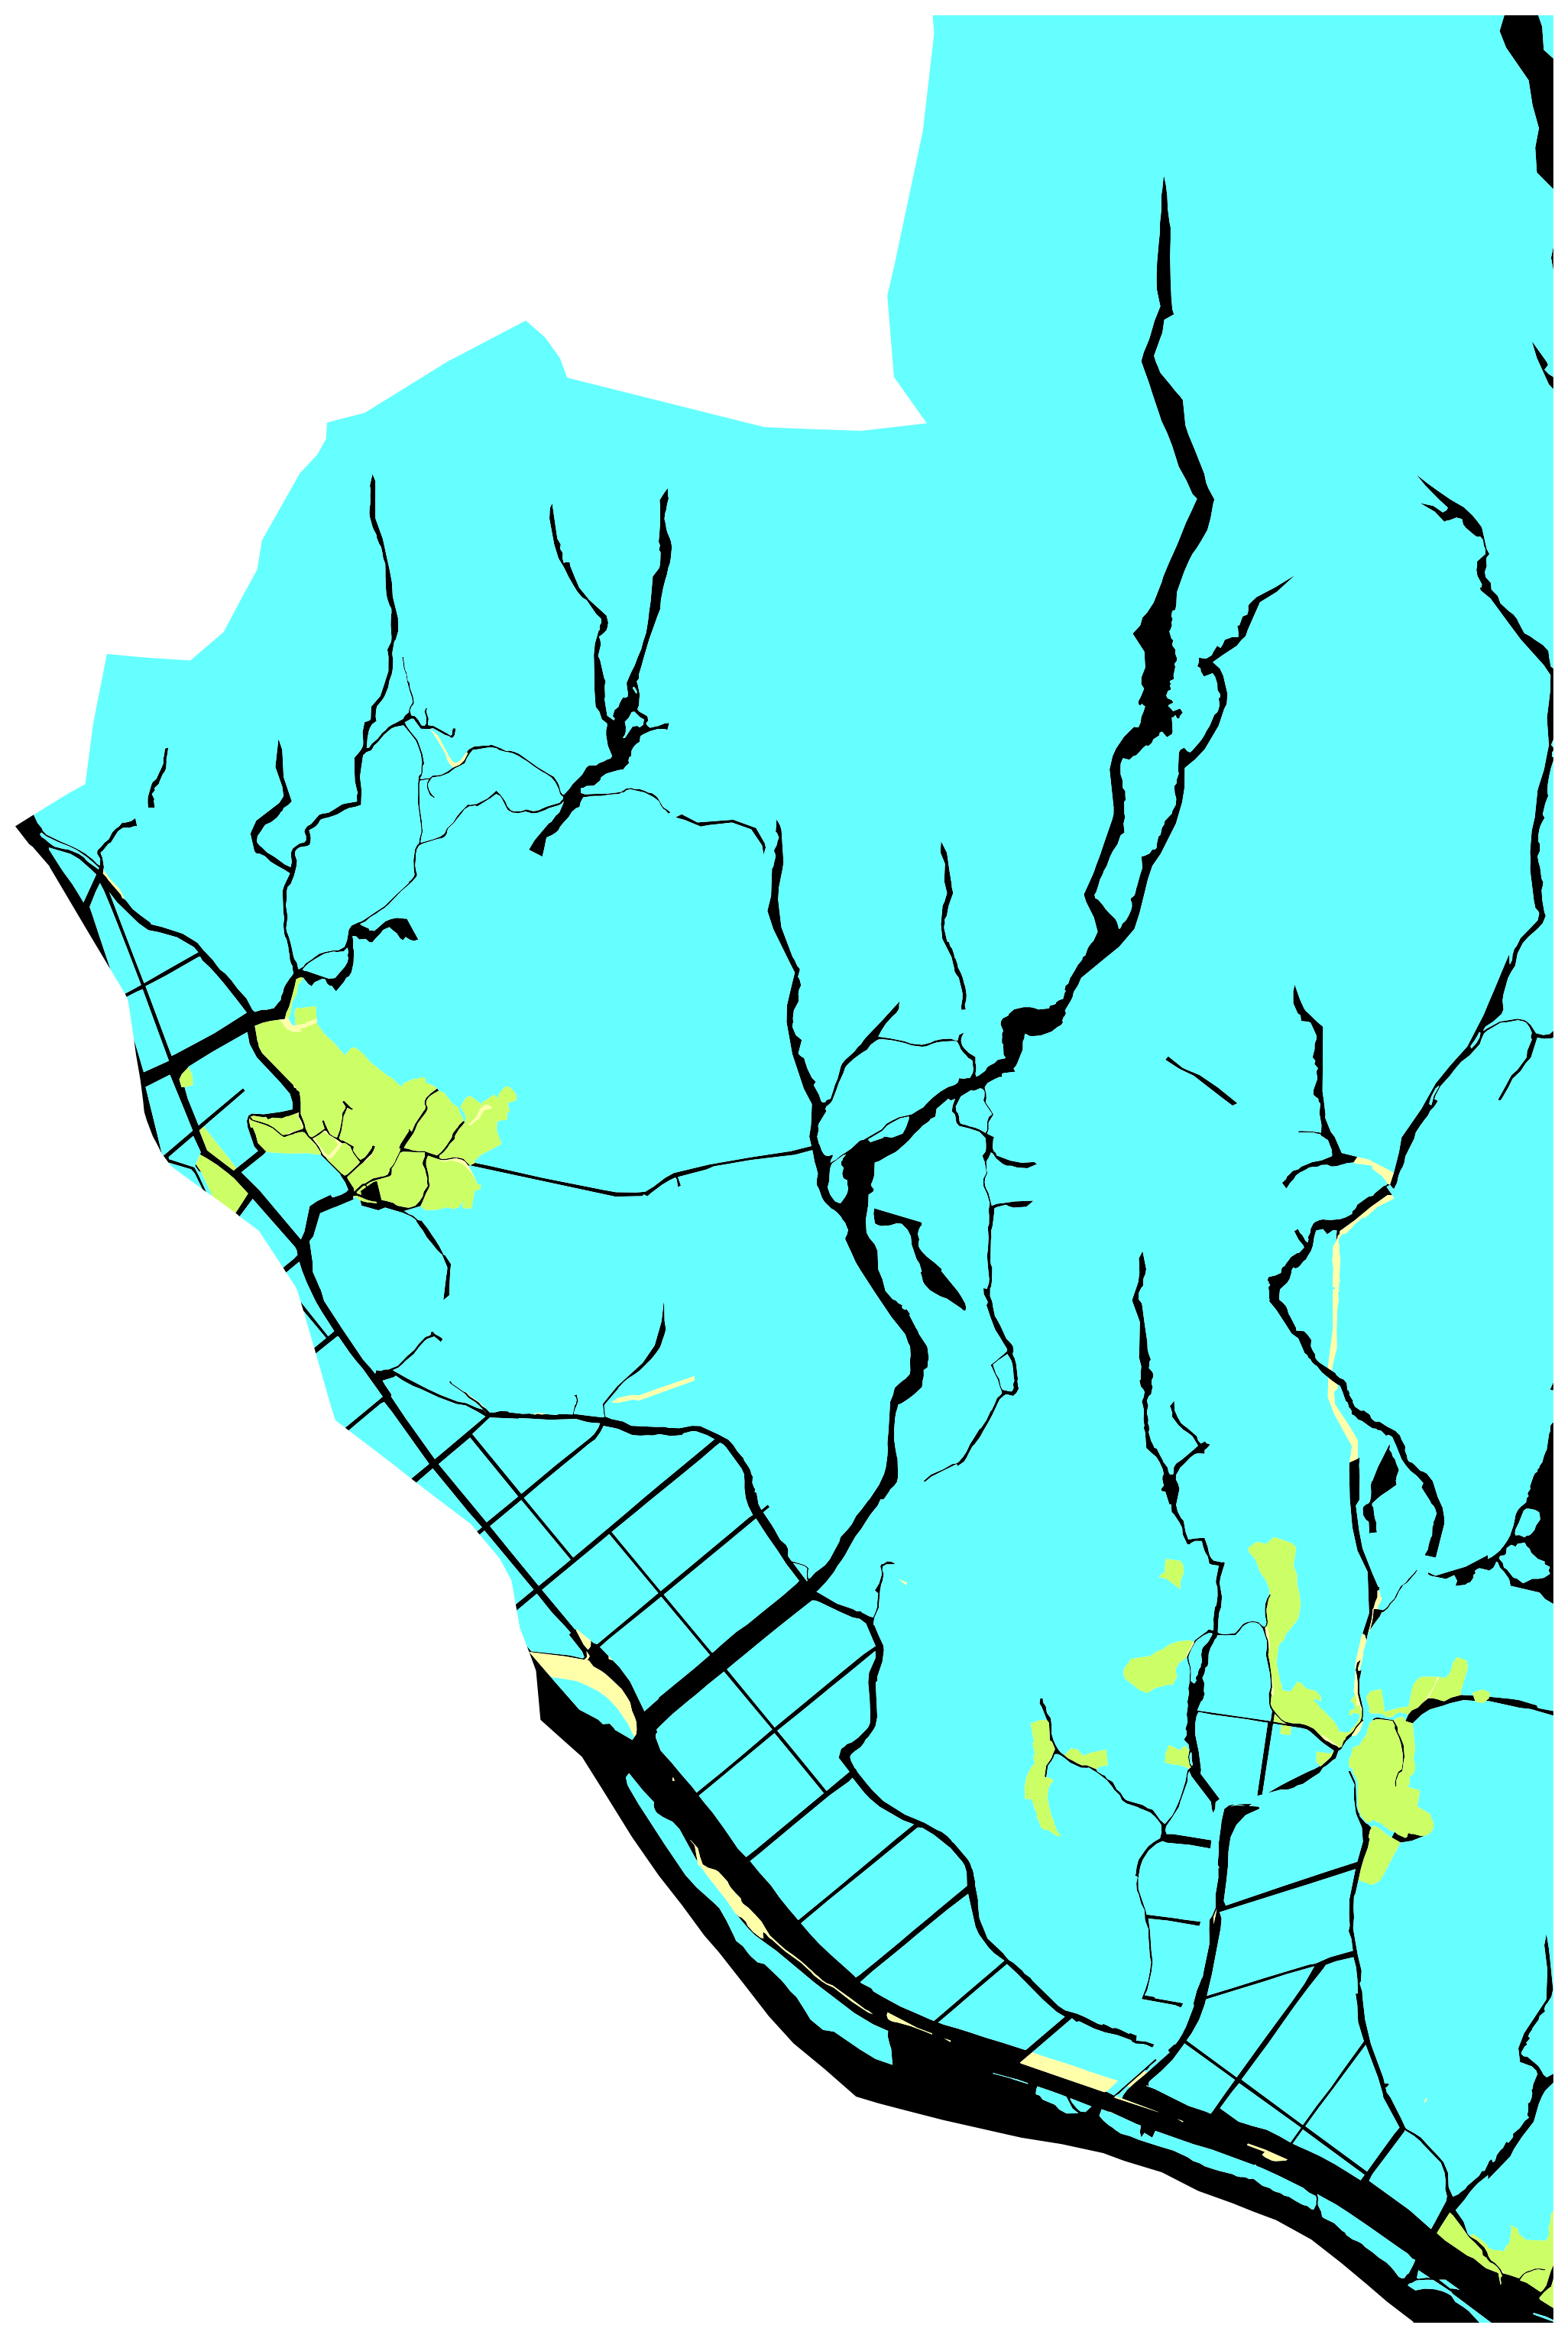

In [142]:
save_to_pic(c, filename)

### 9. 내보낸 picture에 특정 색상이 비율이 너무 큰 것들 분류

In [143]:
import cv2 as cv
import PIL

In [148]:
def classify_pic(filename):
    # Read pic
    img = cv.imread(filename)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # make copy and get dominant color
    img_temp = img.copy()
    unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
    img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = unique[np.argmax(counts)]
    
    return np.array_equal(img_temp[0, 0], np.array([255, 255, 255]))

In [149]:
ans = classify_pic(filename)

In [150]:
ans

False

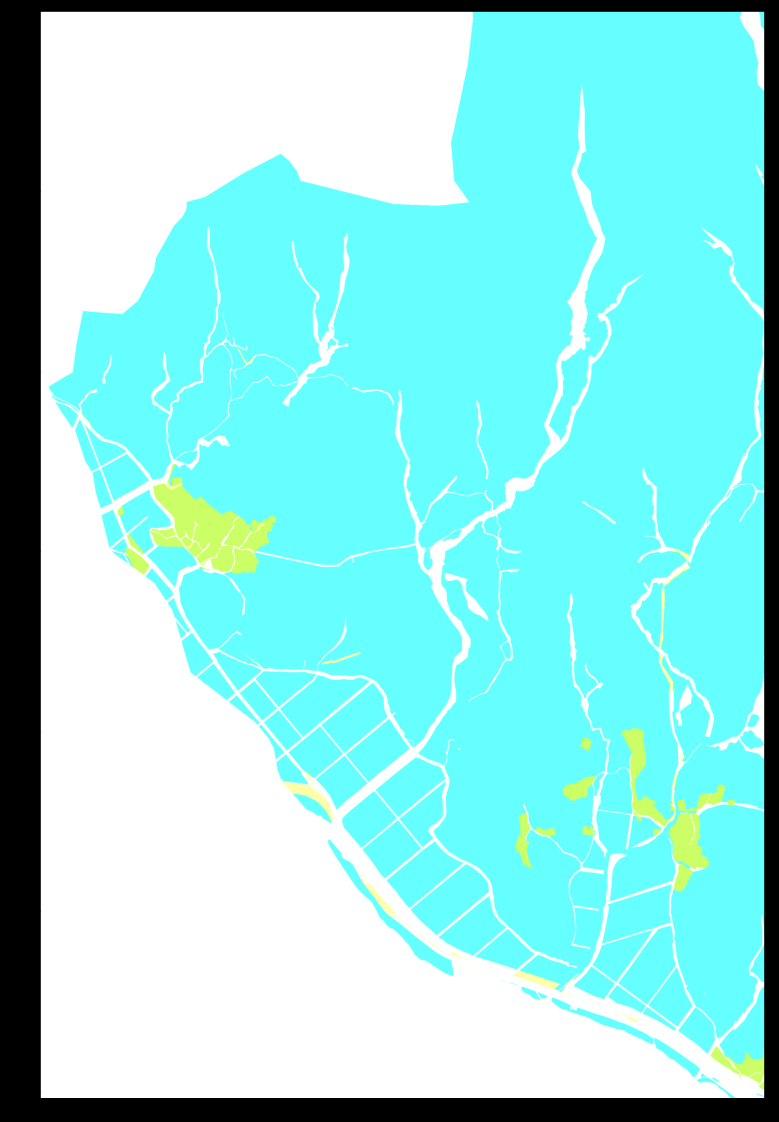

In [117]:
# Read pic

img = cv.imread(filename)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.imshow(img)
fig.set_facecolor("black")
# f.tight_layout()
plt.show()

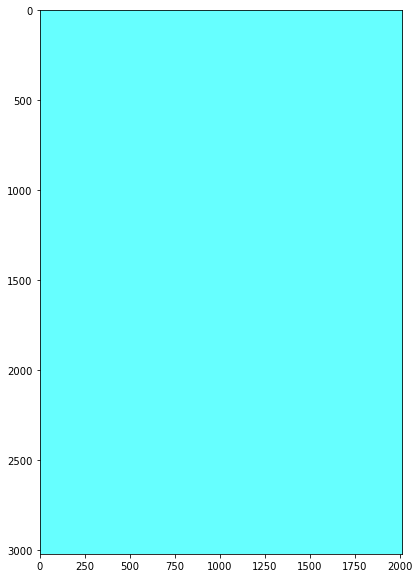

In [91]:
img_temp = img.copy()
unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = unique[np.argmax(counts)]

f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(img_temp)
# f.tight_layout()
plt.show()

In [82]:
np.array_equal(img_temp[0, 0], np.array([0, 0, 0]))

False